# Лабораторная работа №3
### Оценивание параметров нелинейного объекта методом наименьших квадратов

Уравнение исследуемого в лабораторной работе объекта имеет вид:
    \begin{equation}y=f(t,A,B,C,D,E)=A\exp(Bt)\cos(Ct+D)+E+\eta\end{equation}
Уравнение модели объекта:
    \begin{equation}\tilde{y}=\tilde{A}\exp(\tilde{B}t)\cos(\tilde{C}t+\tilde{D})+\tilde{E}\end{equation}
Видно, что объект нелинеен по параметрам $A,B,C,D,E$. 
Данные параметры подлежат оцениванию, $t$ — единственная предикторная переменная, а $\eta$ — случайная ошибка, удовлетворяющая
обычным предположениям: $ E(\eta) = 0, D(\eta)= \sigma^2 $.

Найти оценки параметров $A,B,C,D,E$ предлагается с помощью применения МНК к линеаризованному объекту.

Для линеаризации объекта нужны частные производные от уравнения модели объекта по каждому из параметров. 

Вычислите эти частные производные и запишите уравнение модели линеаризованного объекта:

$$\frac{\partial y}{\partial A} = ... $$
$$\frac{\partial y}{\partial B} = ... $$ 
$$\frac{\partial y}{\partial C} = ... $$
$$\frac{\partial y}{\partial D} = ... $$
$$\frac{\partial y}{\partial E} = ... $$

$$y= ... $$

Теперь перейдем к обработке измерений, полученных c объекта.
Подключим необходимые для работы библиотеки и считаем данные из файла с измерениями.

In [ ]:
import numpy as np
import csv

In [ ]:
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
import pandas as pd

In [ ]:
filename='Kuzina_.csv'

In [ ]:
data = pd.read_csv(filename, sep=';',header=None, names=['t', 'U'])
data.dtypes

t      int64
U    float64
dtype: object

In [ ]:
t_arr = data['t'].values
u_arr = data['U'].values

Построим зависимость измеpений от времени:

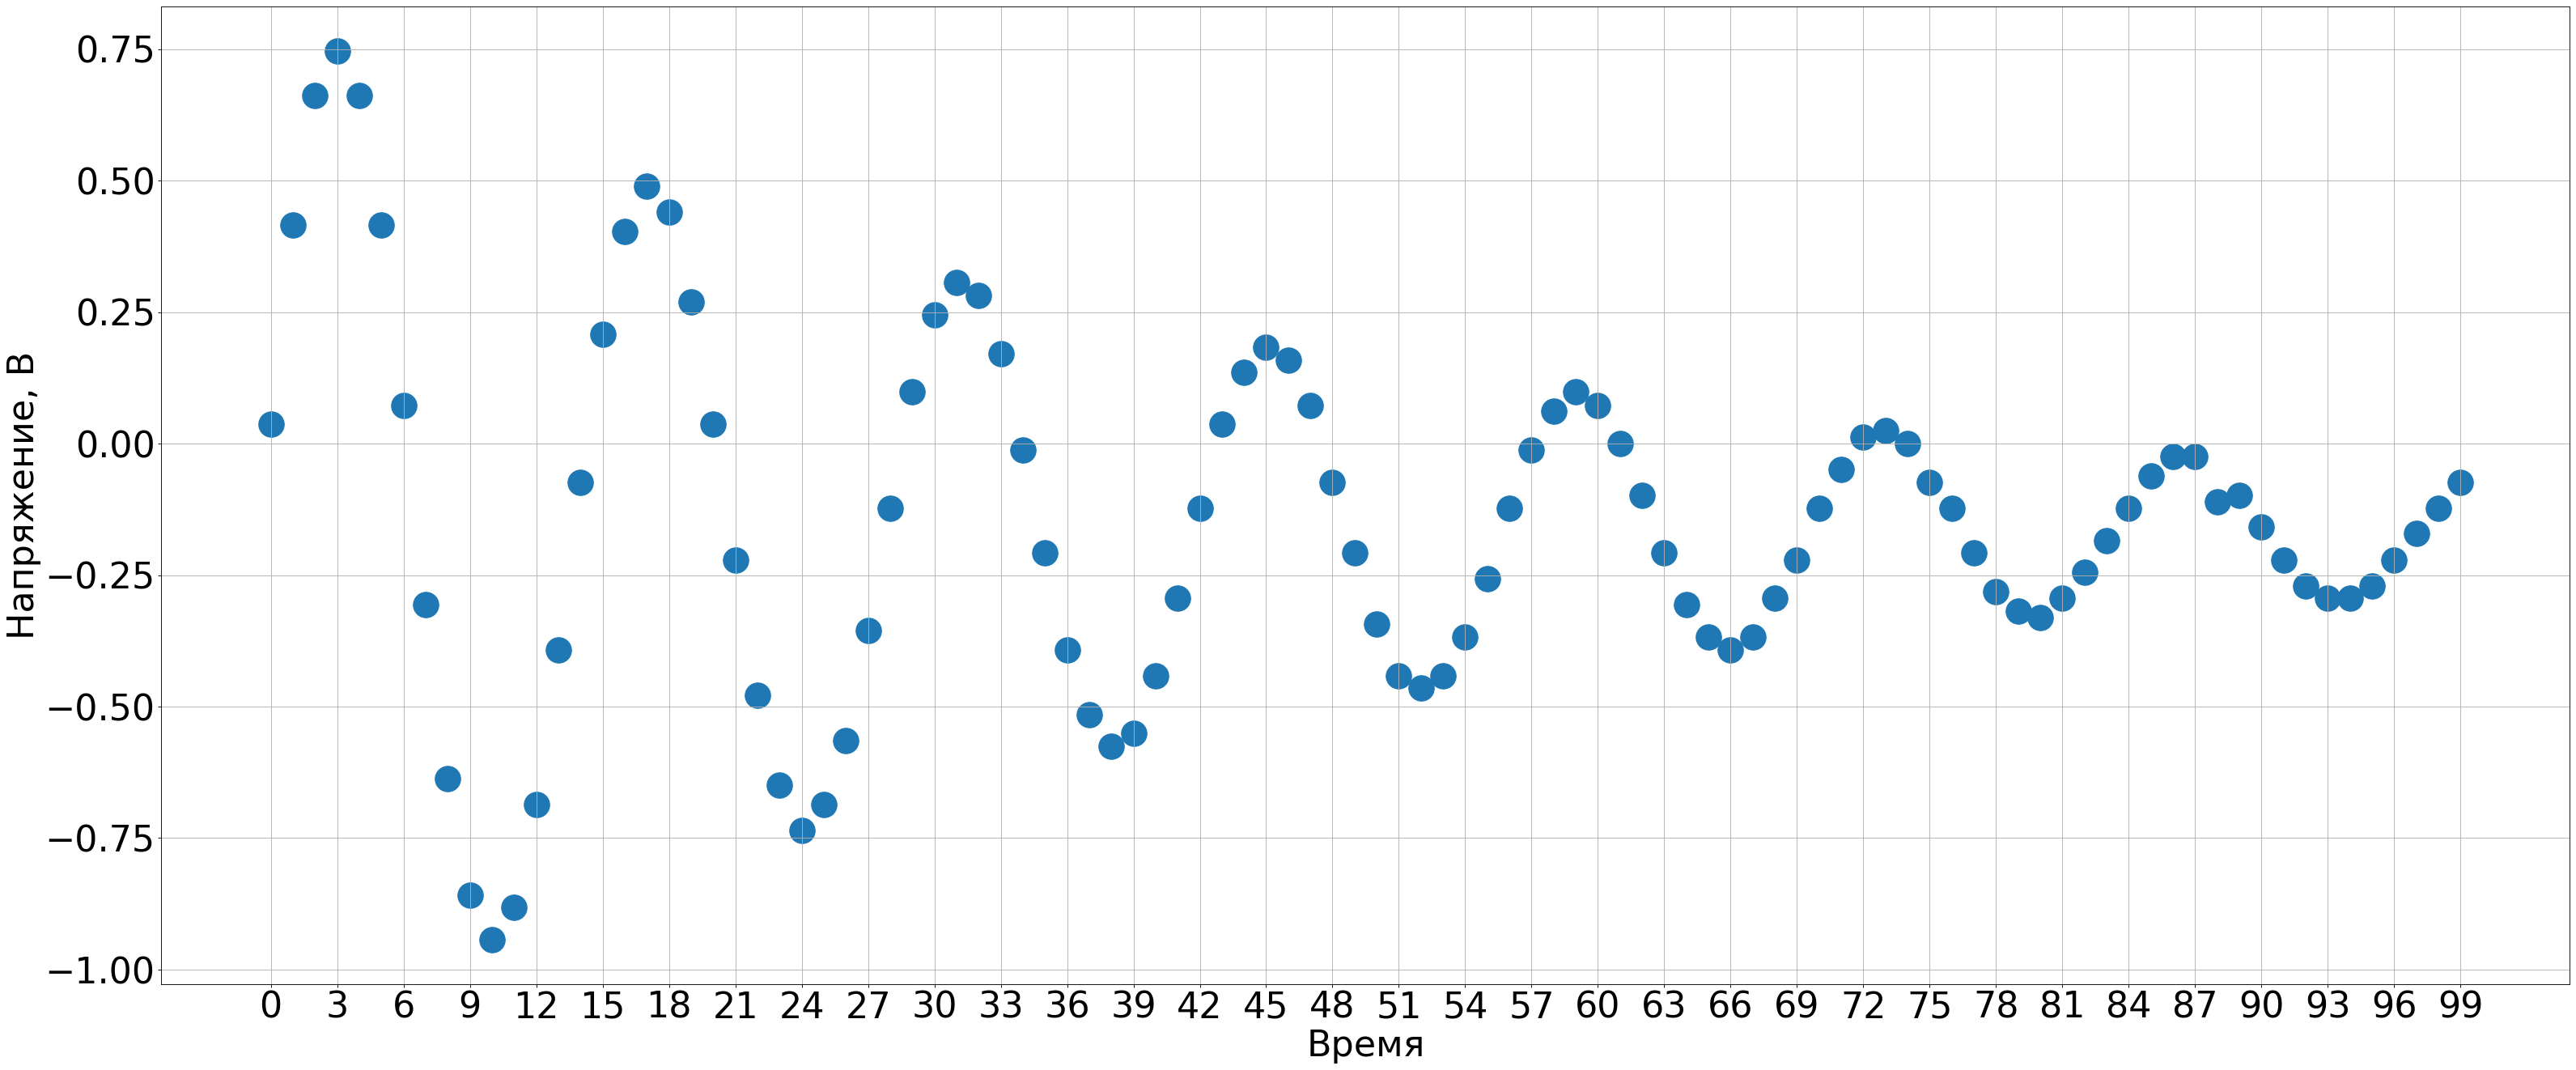

In [ ]:
matplotlib.rcParams.update({'font.size': 40})
fig, ax = plt.subplots()
ax.scatter(t_arr,u_arr, s=8e2)
plt.xticks(np.arange(0., 101, step=3))
plt.grid(True)
plt.xlabel('Время')
plt.ylabel('Напряжение, В')
fig.set_figwidth(48)
fig.set_figheight(20)
fig.set_dpi(80)

## Начальные приближения

Исходя из графика и уравнения объекта, подберите начальное приближение:
$A_{0},B_{0},C_{0},D_{0},E_{0}$

ПРИМЕЧАНИЕ: если в процессе оценивания параметров МНК разойдется, то возможно стоит выбрать более точное начальное приближение.

Minimizer is Minuit / Migrad  
Chi2                      =    0.0352037  
NDf                       =           95  
Edm                       =  1.56991e-08  
NCalls                    =          184  
p0                        =     0.984497   +/-   0.00864049    
p1                        =    0.0228419   +/-   0.00031176    
p2                        =      0.44895   +/-   0.000299074   
p3                        =      4.85794   +/-   0.00840548    
p4                        =    -0.166837   +/-   0.00193746  

In [ ]:
c_init = np.array([
                    1., #A amplitude
                    0.02, #B ln2/t_1/2
                    2*np.pi/13, #C 2pi/T
                    1.5*np.pi,  #D phase
                    -0.075 #-0.166837 # E sistimatic uncertaintes
                    ])
type(size(c_init))
t_1_2 = np.log(2)/0.0228419
T = 2*np.pi/0.44895
ph = 4.85794/np.pi
print(t_1_2,T,ph)

30.345425755298173 13.995289691902407 1.5463303284876841


Определите функции, возвращающие значения частных производных:

In [ ]:
from sympy import *

In [ ]:
A = symbols('A')
B = symbols('B')
C = symbols('C')
D = symbols('D')
E = symbols('E')
t = symbols('t')
# y_d = symbols('y_d')
y = Function('y')(A,B,C,D,E,t)

In [ ]:
y = A*exp(-B*t)*cos(C*t+D)+E
pretty_print(y)
# y
print(diff(y,A),diff(y,B),diff(y,C),diff(y,D),diff(y,E),sep='\n')

   -B⋅t                 
A⋅ℯ    ⋅cos(C⋅t + D) + E
exp(-B*t)*cos(C*t + D)
-A*t*exp(-B*t)*cos(C*t + D)
-A*t*exp(-B*t)*sin(C*t + D)
-A*exp(-B*t)*sin(C*t + D)
1


In [ ]:
def psi_row(y,t_i,pars_i):
  row = np.array([
                diff(y,A).subs([(t, t_i),(A, pars_i[0]),(B, pars_i[1]),(C, pars_i[2]),(D, pars_i[3]),(E, pars_i[4])]).evalf(), 
                diff(y,B).subs([(t, t_i),(A, pars_i[0]),(B, pars_i[1]),(C, pars_i[2]),(D, pars_i[3]),(E, pars_i[4])]).evalf(), 
                diff(y,C).subs([(t, t_i),(A, pars_i[0]),(B, pars_i[1]),(C, pars_i[2]),(D, pars_i[3]),(E, pars_i[4])]).evalf(), 
                diff(y,D).subs([(t, t_i),(A, pars_i[0]),(B, pars_i[1]),(C, pars_i[2]),(D, pars_i[3]),(E, pars_i[4])]).evalf(), 
                diff(y,E).subs([(t, t_i),(A, pars_i[0]),(B, pars_i[1]),(C, pars_i[2]),(D, pars_i[3]),(E, pars_i[4])]).evalf()   
  ])
  return row
# psi_row(y,1,np.array([2,5,6,3,6]))

In [ ]:
def psi_matr(y,t_arr,pars):
  psi = np.zeros((size(t_arr),size(pars)))
  for i in range(size(t_arr)):
    psi[i] = psi_row(y,t_arr[i],pars)
  return psi
psi_matr(y,t_arr,c_init).shape

(100, 5)

In [ ]:
def e_row(exp_i, y, t_i, pars_i):
  e_j = exp_i - y.subs([(t, t_i),(A, pars_i[0]),(B, pars_i[1]),(C, pars_i[2]),(D, pars_i[3]),(E, pars_i[4])]).evalf()
  return e_j

In [ ]:
def e_matr(U, y,t_arr,pars):
  e = np.zeros(size(t_arr))
  for i in range(size(t_arr)):
    e[i] = e_row(U[i], y, t_arr[i], pars)
  return e
e_matr(u_arr,y,t_arr,c_init).shape

(100,)

Реализуйте МНК для линеаризованного объекта и найдите оценку параметров: $\tilde{A},\tilde{B},\tilde{C},\tilde{D},\tilde{E}$

Критерий качества
$J(\hat{\bar{c}}) = [\bar{e}(j)-\Psi(j)(\tilde{\bar{c}}-\hat{\bar{c}}(j))]^{T}R[\bar{e}(j)-\Psi(j)(\tilde{\bar{c}}-\hat{\bar{c}}(j))]$  
Оценка на j-ой итерации 
$\hat{\bar{c}}(j+1) = \hat{\bar{c}}(j)+(\Psi(j)^{T}R\Psi(j)^{-1}\Psi(j)^{T}R\bar{e}(j)$  
Условие остановки  
$\frac{|J(j+1)-J(i)|}{|J(j+1)|}<\varepsilon$

где  
$\bar{e}(j) = \begin{pmatrix}
y(1)-\tilde{\Psi}(u(1),\hat{\bar{c}}(j))\\
...\\
y(N)-\tilde{\Psi}(u(N),\hat{\bar{c}}(j))\\
\end{pmatrix}$   
$\Psi = \left.\begin{pmatrix}
\frac{\partial\hat{\Psi}(u(1),\tilde{\bar{c}})}{\partial{\tilde{{c_1}}}}& \frac{\partial\hat{\Psi}(u(1),\tilde{\bar{c}})}{\partial{\tilde{{c_2}}}}& ...& \frac{\partial\hat{\Psi}(u(1),\tilde{\bar{c}})}{\partial{\tilde{{c_m}}}}\\
& ...&\\
\frac{\partial\hat{\Psi}(u(N),\tilde{\bar{c}})}{\partial{\tilde{{c_1}}}}& \frac{\partial\hat{\Psi}(u(N),\tilde{\bar{c}})}{\partial{\tilde{{c_2}}}}& ...& \frac{\partial\hat{\Psi}(u(N),\tilde{\bar{c}})}{\partial{\tilde{{c_m}}}}\\
\end{pmatrix}\right|_{\tilde{\bar{c}} = \hat{\bar{c}}(j)}$


In [ ]:
def LS(U,t,c_0,y,eps):
  N = size(t)
  c_prev = c_0.reshape(len(c_0),1) #column
  c_curr = np.zeros(c_prev.shape)
  # print(c_curr)
  # res_arr = np.array([])
  iter = 0
  J_prev = 0
  print('c_curr', c_prev.transpose())
  while True:
    print("iter: ",iter)
    psi_j = psi_matr(y,t,c_prev)
    e_j = e_matr(U, y,t,c_prev)
    e_j = e_j.reshape(len(e_j),1) #column

    matr_tmp = np.matmul( np.transpose(psi_j), np.eye(N) )
    matr1 = np.linalg.inv( np.matmul( matr_tmp, psi_j ) )
    matr2 = np.matmul( matr_tmp, e_j )
    c_curr = c_prev + np.matmul(matr1,matr2)
    print('c_curr', c_curr.transpose())

    res = e_j - np.matmul( psi_j, (c_prev-c_curr) )
    # res_arr = np.append(res_arr,[res])
    J_curr = np.matmul( np.matmul( np.transpose(res), np.eye(N) ), res)
    
    if iter == 0:
      J_prev = J_curr
      c_prev = c_curr
      iter += 1
      continue
    print(np.abs(J_prev-J_curr)/np.abs(J_curr))
    if( (np.abs(J_prev-J_curr)/np.abs(J_curr))<eps ):
      break

    J_prev = J_curr
    c_prev = c_curr
    iter += 1      

  return c_curr #,res_arr

In [ ]:
c_LS = LS(u_arr,t_arr,c_init,y,1e-4)

c_curr [[ 1.          0.02        0.48332195  4.71238898 -0.075     ]]
iter:  0
c_curr [[ 1.1435011   0.04196452  0.47092402  4.62237992 -0.1707645 ]]
iter:  1
c_curr [[ 1.01764811  0.0293598   0.43354216  4.95674619 -0.17222628]]
[[3.06842305]]
iter:  2
c_curr [[ 1.06802772  0.03037338  0.45172142  4.83562888 -0.16808837]]
[[0.75287278]]
iter:  3
c_curr [[ 0.96636042  0.02168363  0.44719091  4.87994323 -0.16680848]]
[[3.34283894]]
iter:  4
c_curr [[ 0.98729347  0.0230046   0.44896228  4.85659059 -0.16694862]]
[[6.90345494]]
iter:  5
c_curr [[ 0.98445209  0.02284083  0.44893901  4.85815281 -0.16684074]]
[[2.56227646]]
iter:  6
c_curr [[ 0.98449135  0.02284215  0.4489507   4.85791715 -0.16684185]]
[[0.01303097]]
iter:  7
c_curr [[ 0.98447319  0.02284127  0.44895045  4.85792316 -0.16684133]]
[[6.29604461e-05]]


In [ ]:
y.subs([(A, c_LS[0]),(B, c_LS[1]),(C, c_LS[2]),(D, c_LS[3]),(E, c_LS[4])])

-0.166841325383839 + 0.984473192373934*exp(-0.0228412692236841*t)*cos(0.448950448895776*t + 4.85792315922366)

In [ ]:
x = np.linspace(0.,100.,num=1000)
y_LS = np.zeros(size(x))
for i in range(size(x)):
  y_LS[i]= y.subs([(t,x[i]),(A, c_LS[0]),(B, c_LS[1]),(C, c_LS[2]),(D, c_LS[3]),(E, c_LS[4])]).evalf()

Постройте графики для исходных измерений и полученной модели объекта:

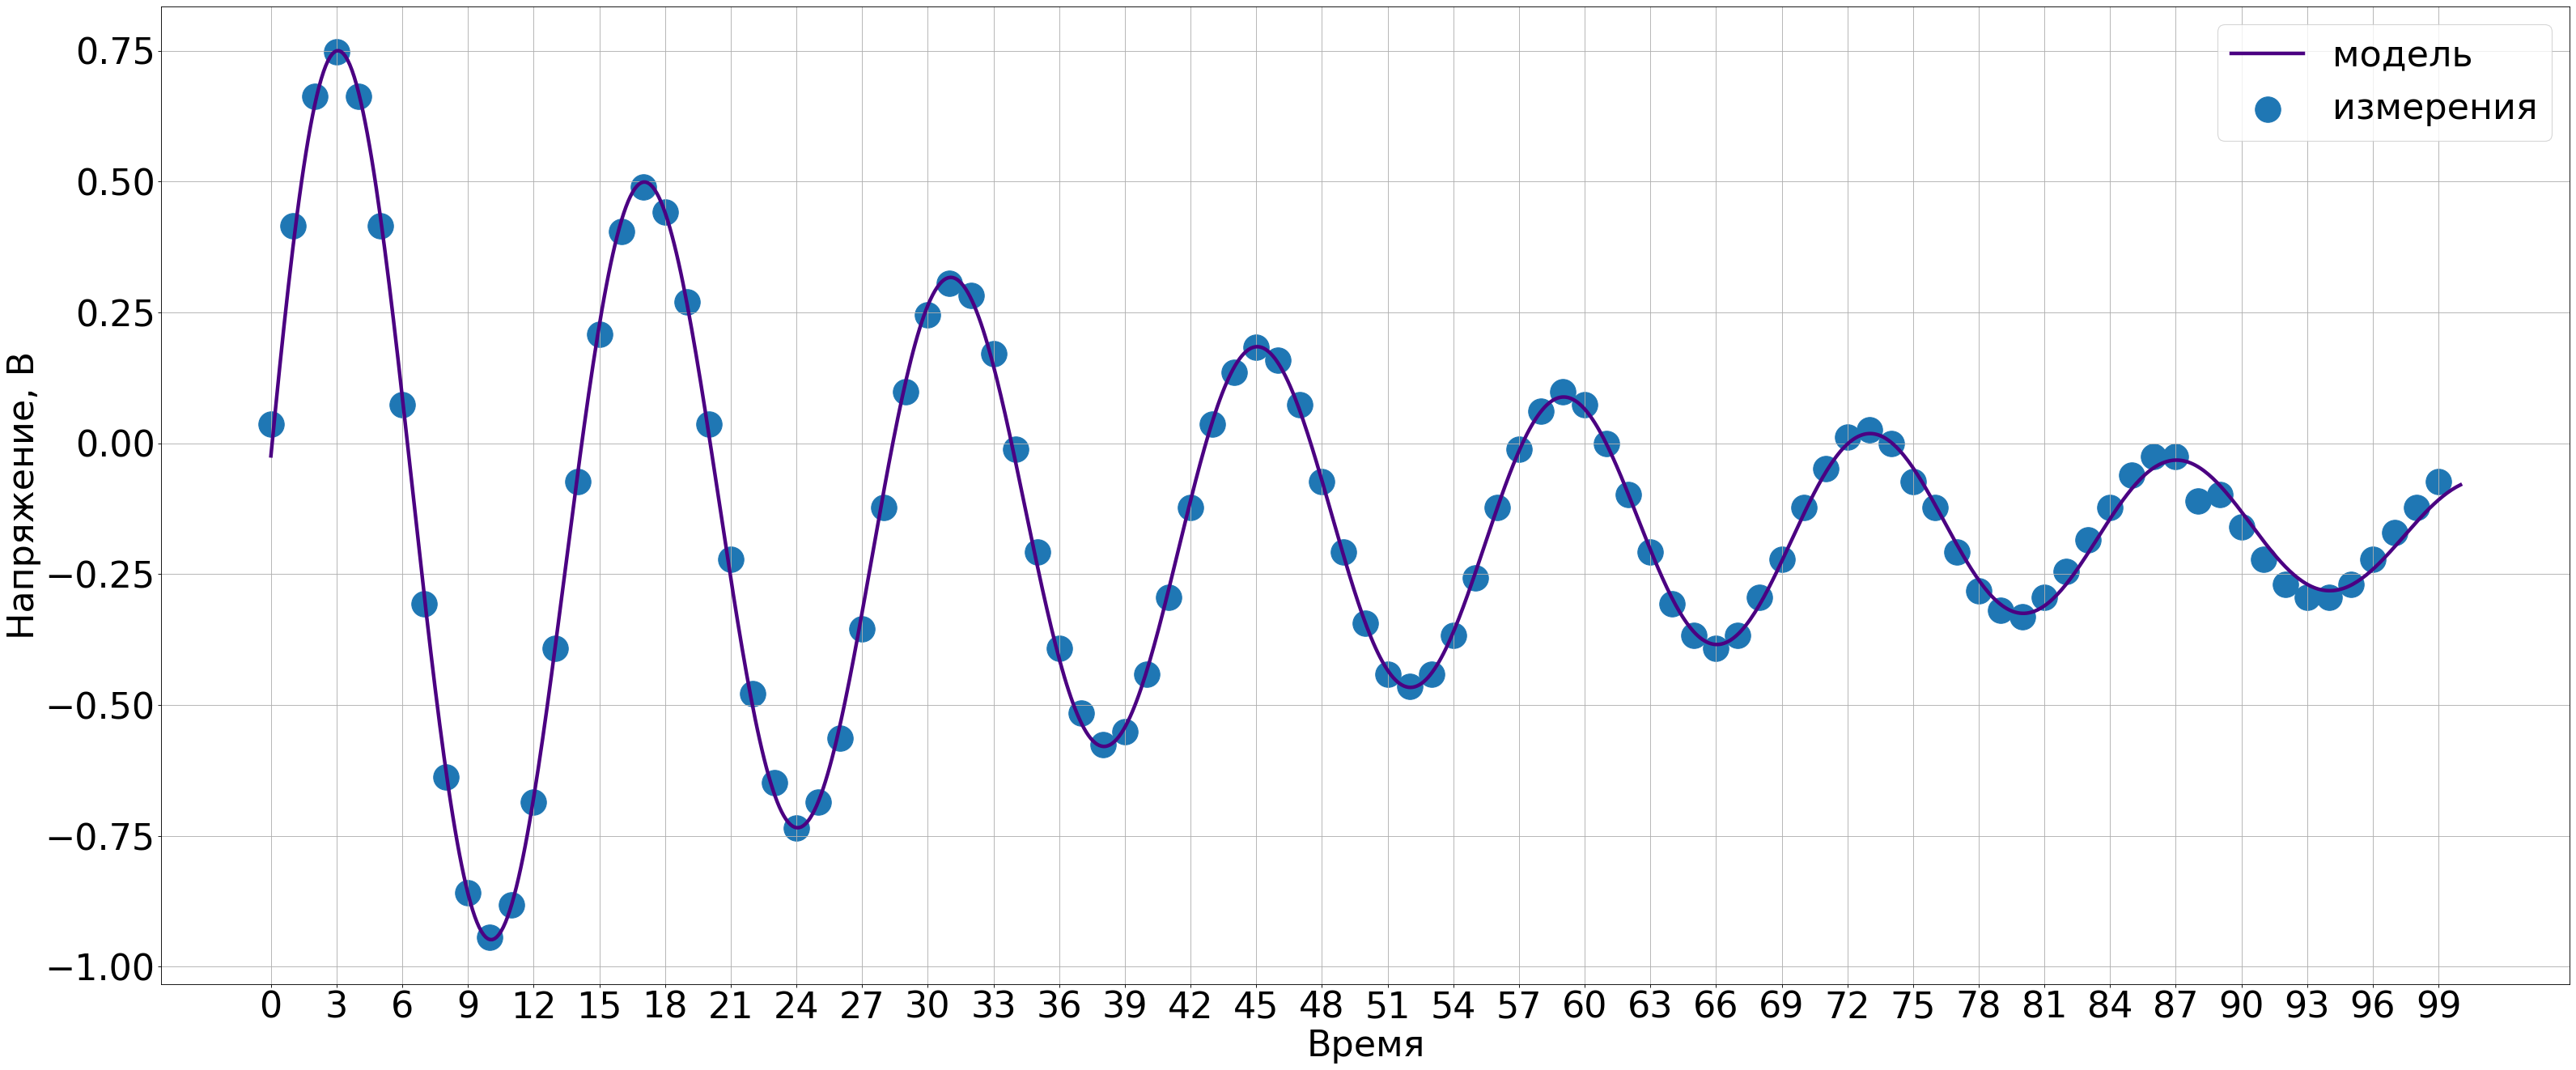

In [ ]:
fig, ax = plt.subplots()
ax.scatter(t_arr,u_arr, s=8e2, label='измерения')
plt.plot(x, y_LS, color='indigo', linewidth='4', label='модель')
plt.xticks(np.arange(0., 101, step=3))
plt.grid(True)
plt.xlabel('Время')
plt.ylabel('Напряжение, В')
ax.legend()
fig.set_figwidth(48)
fig.set_figheight(20)
fig.set_dpi(80)


Постройте график остатков и сделайте выводы о применимости линеаризации для оценки параметров нелинейных объектов:

In [ ]:
res_LS = np.zeros(size(t_arr))
for i in range(size(t_arr)):
  res_LS[i]= np.abs(y.subs([(t,t_arr[i]),(A, c_LS[0]),(B, c_LS[1]),(C, c_LS[2]),(D, c_LS[3]),(E, c_LS[4])]).evalf()-u_arr[i])

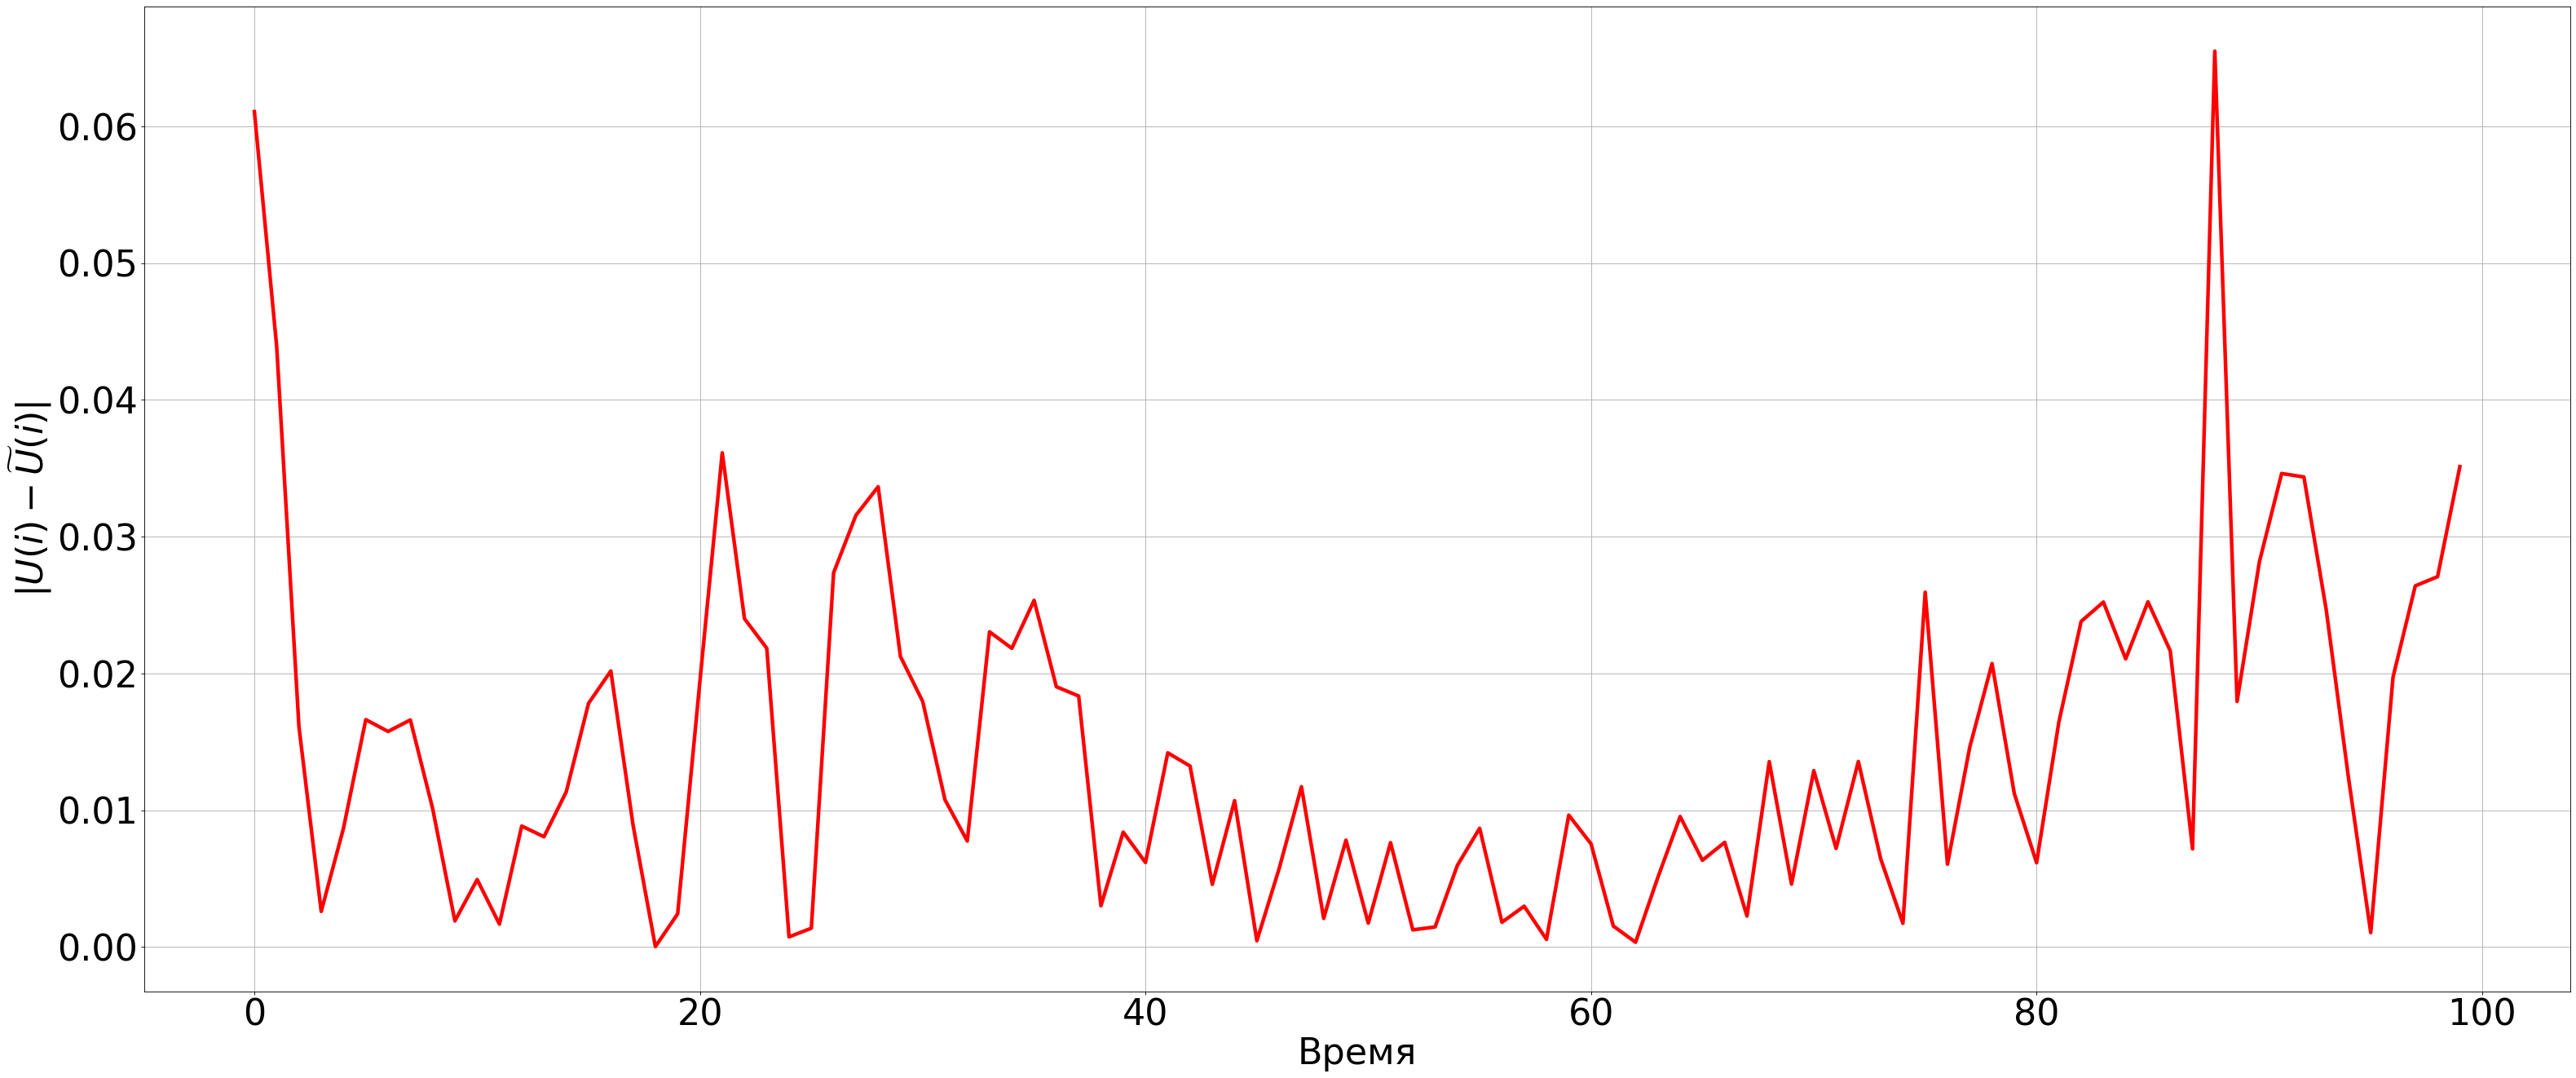

In [ ]:
fig, ax = plt.subplots()
plt.plot(t_arr, res_LS, color='r', linewidth='4')
plt.grid(True)
plt.ylabel(r'$|U(i)-\widetilde{U}(i)|$')
plt.xlabel('Время')
fig.set_figwidth(48)
fig.set_figheight(20)
fig.set_dpi(80)

**После выполнения лабораторной работы необходимо написать краткий отчет, который должен включать в себя:**
    - титульный лист
    - описание моделируемого объекта
    - математические выкладки о применении МНК для оценки параметров моделируемого объекта
    - выводы о применимости линеаризации для оценки параметров нелинейных объектов